<a href="https://colab.research.google.com/github/jiw3026/SML/blob/main/boosting_Ada%2CGrad%2CXgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Boosting: 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법

Adaboost,GradientBoost, XgBoost를 사용

## 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

## 데이터 로딩 및 확인

In [13]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [ ]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.235555,0.174797,1.374005,20.356410,582.731618,0.018994,30.774814,14.110562,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,880.000000,0.026000,37.000000,21.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.400000,51.000000,1576.000000,0.039149,53.000000,28.000000,96.000000
75%,1651.000000,17.500000,20.050000,0.000000,3.400000,68.500000,1994.000000,0.051000,68.000000,36.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


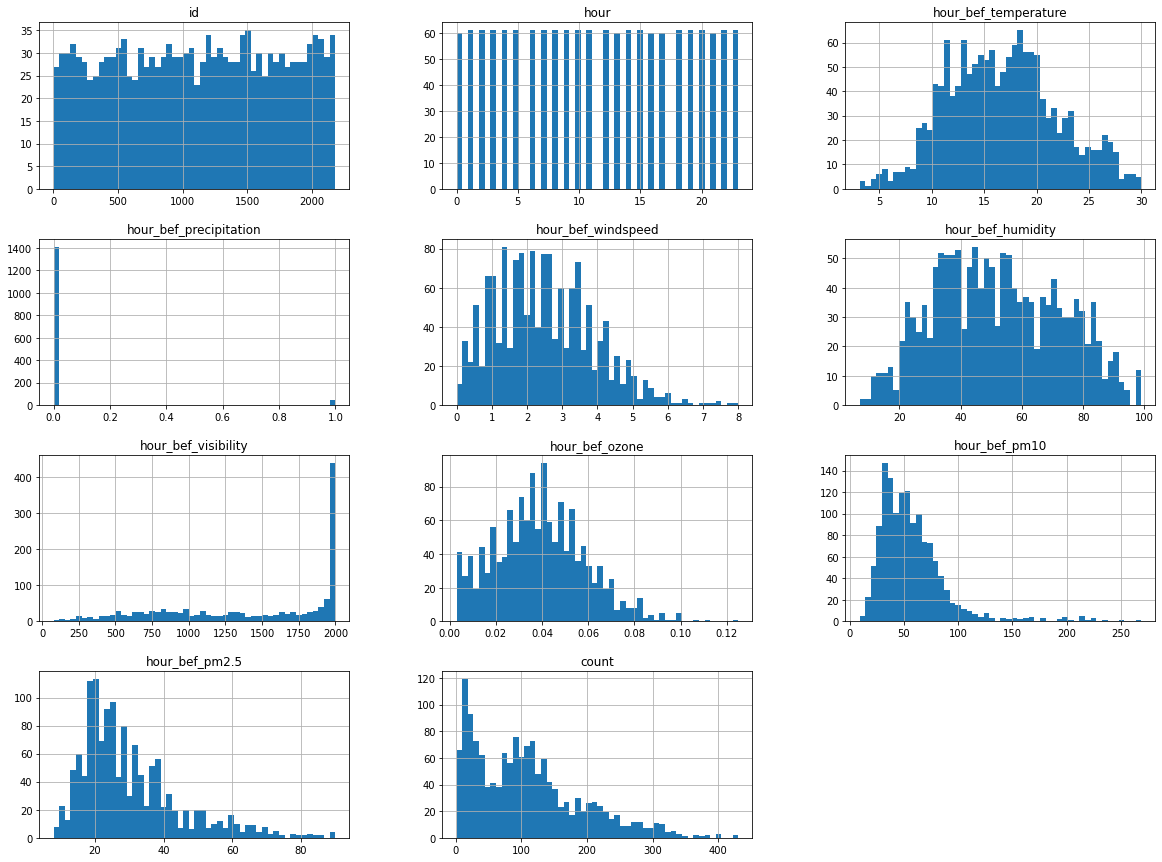

In [4]:
import matplotlib.pyplot as plt
train.hist(bins=50,figsize=(20,15))
plt.show()

In [6]:
corr_matrix = train.corr()
corr_matrix['count'].sort_values(ascending=False)

count                     1.000000
hour                      0.626047
hour_bef_temperature      0.619404
hour_bef_ozone            0.477614
hour_bef_windspeed        0.459906
hour_bef_visibility       0.299094
id                       -0.002131
hour_bef_pm10            -0.114288
hour_bef_pm2.5           -0.134293
hour_bef_precipitation   -0.163985
hour_bef_humidity        -0.471142
Name: count, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88496158d0>,
      dtype=object)

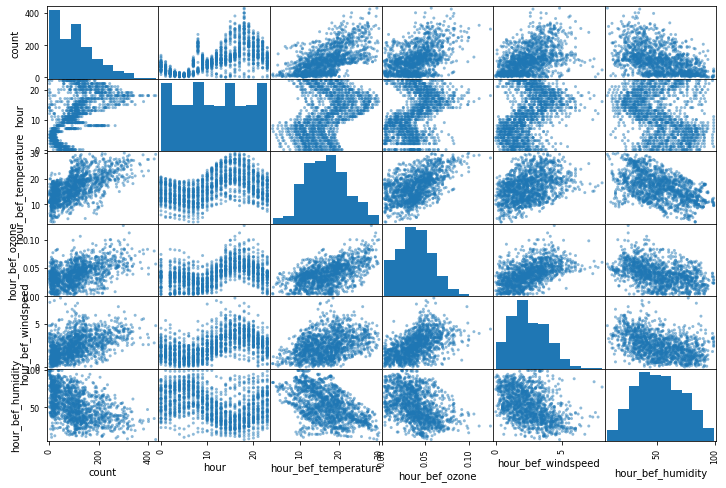

In [7]:
from pandas.plotting import scatter_matrix
attributes = ['count','hour','hour_bef_temperature','hour_bef_ozone','hour_bef_windspeed','hour_bef_humidity']
scatter_matrix(train[attributes],figsize=(12,8))

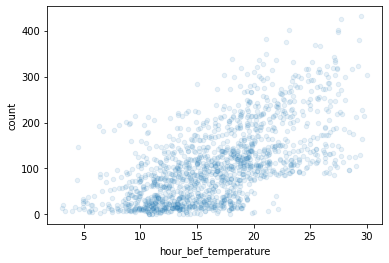

In [8]:
train.plot(kind="scatter", x="hour_bef_temperature", y="count", alpha=0.1)

In [14]:
train.fillna(0,inplace = True)
test.fillna(0,inplace = True)

In [15]:
#이상치 처리
colL  = ['hour','hour_bef_temperature', 'hour_bef_precipitation', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_visibility',
      'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count']

train_iqr = train.copy()
for col in colL:
  Q1 = train_iqr[col].quantile(.25)
  Q3 = train_iqr[col].quantile(.75)
  IQR = Q3 - Q1
  train_del = train_iqr[((Q1-1.5*IQR) > train_iqr[col]) | ((Q3+1.5*IQR) < train_iqr[col])]
  train_iqr = train_iqr.drop(train_del.index, axis=0)
train_iqr

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
5,13,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0
6,14,3,10.6,0.0,1.5,58.0,1548.0,0.038,62.0,33.0,23.0
7,16,21,16.0,0.0,6.0,21.0,1961.0,0.050,90.0,28.0,146.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


In [16]:
#train 데이터 내에서 트레이닝, 테스트 데이터셋 분리함.
from sklearn.model_selection import train_test_split
train_x = train_iqr.drop(['count'],axis = 1)
train_y = train_iqr['count']
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

In [17]:
#X_train 데이터 표준화
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)

In [18]:
#X_test 데이터 표준화
X_test=scaler.transform(X_test)

## 모델 정의 및 학습

In [19]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.5, n_estimators=200)

In [20]:
#GradientBoost
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_test, y_pred)
            for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=197)

In [70]:
#xgboost
import xgboost as xgb
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=200, colsample_bylevel=0.8, colsample_bytree=0.7, eta=0.1, max_depth=6)
xgb_reg.fit(X_train,y_train)

XGBRegressor(colsample_bylevel=0.8, colsample_bytree=0.7, eta=0.1, max_depth=6,
             n_estimators=200, objective='reg:squarederror')

In [24]:
#파라미터 서치
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[100,200],
    'max_depth': [6,8,10,12],
    'eta':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
    'colsample_bylevel':[0.6, 0.7, 0.8, 0.9],
}
grid_search = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror',), param_grid, cv=2, n_jobs=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=42),
             n_jobs=1,
             param_grid={'colsample_bylevel': [0.6, 0.7, 0.8, 0.9],
                         'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                         'max_depth': [6, 8, 10, 12],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
scores_df = pd.DataFrame(grid_search.cv_results_)
scores_df

In [38]:
grid_search.best_params_

{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.7,
 'eta': 0.1,
 'max_depth': 6,
 'n_estimators': 200}

In [68]:
scores_df['rmse'] = np.sqrt(-scores_df['mean_test_score'])

In [69]:
#각 파라미터 값 별 rmse 비교
scores_df[['param_colsample_bylevel','param_colsample_bytree','param_eta','param_max_depth','param_n_estimators','mean_test_score','rmse']].sort_values('mean_test_score', ascending=False)

,param_colsample_bylevel,param_colsample_bytree,param_eta,param_max_depth,param_n_estimators,mean_test_score,rmse
577,0.8,0.7,0.1,6,200,-1691.455556,41.127309
633,0.8,0.7,0.8,6,200,-1691.455556,41.127309
609,0.8,0.7,0.5,6,200,-1691.455556,41.127309
625,0.8,0.7,0.7,6,200,-1691.455556,41.127309
601,0.8,0.7,0.4,6,200,-1691.455556,41.127309
...,...,...,...,...,...,...,...
60,0.6,0.6,0.8,10,100,-2016.595016,44.906514
12,0.6,0.6,0.2,10,100,-2016.595016,44.906514
52,0.6,0.6,0.7,10,100,-2016.595016,44.906514
44,0.6,0.6,0.6,10,100,-2016.595016,44.906514


## 학습 된 모델로 예측 데이터 생성 및 평가


In [71]:
#rmse 평가
from pandas.core.nanops import F
from sklearn.metrics import mean_squared_error

pred_ada = ada_clf.predict(X_test)
pred_gra = gbrt_best.predict(X_test)
pred_xgb = xgb_reg.predict(X_test)
li = [pred_ada, pred_gra, pred_xgb]
for i in li:
  mse = mean_squared_error(y_test, i)
  rmse = np.sqrt(mse)
  print(rmse)

59.367276718521836
37.91842215107301
35.20334344669271


Adaboost의 rmse: 59.367276718521836

Gradientboost의 rmse: 37.91842215107301

xgboost의 rmse: 35.20334344669271

In [72]:
#accuracy 평가
li = [ada_clf, gbrt_best, xgb_reg]
for i in li:
  acc_train = i.score(X_test, y_test)
  print(acc_train)

0.007936507936507936
0.7894663310154186
0.8185366727465971



Adaboost의 accuracy: 0.007936507936507936

Gradientboost의 accuracy: 0.7894663310154186

xgboost의 accuracy: 0.8114319460200251